In [1]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm

from astropy.cosmology import Planck18 as cosmo_astropy
from astropy import units as u
import camb
from cosmology import Cosmology
import glass
import glass.ext.camb
import h5py

import sys
sys.path.append('../code')
import plotter
import utils

%matplotlib inline
%load_ext autoreload
%autoreload 2

Note: you'll have to install glass (version 2025.1), camb, and also glass.ext.camb (literally 'pip install glass.ext.camb')

# Generate tracer samples

In [2]:
save = True
tag_mock = ''

## Matter

In [3]:
# creating a numpy random number generator for sampling
seed = 42
rng = np.random.default_rng(seed=seed)

# cosmology for the simulation
# planck18, via: https://docs.astropy.org/en/stable/api/astropy.cosmology.realizations.Planck18.html

h = cosmo_astropy.h
Oc = cosmo_astropy.Om0 - cosmo_astropy.Ob0
Ob = cosmo_astropy.Ob0
print(f"Using cosmology: h = {h}, Oc = {Oc}, Ob = {Ob}")

# h = 0.6766
# Oc = 0.30966
# Ob = 0.04897

# basic parameters of the simulation
nside = lmax = 128

# set up CAMB parameters for matter angular power spectrum
pars = camb.set_params(
    H0=100 * h,
    omch2=Oc * h**2,
    ombh2=Ob * h**2,
    NonLinear=camb.model.NonLinear_both,
)

# get the cosmology from CAMB
cosmo = Cosmology.from_camb(pars)

Using cosmology: h = 0.6766, Oc = 0.26069, Ob = 0.04897


In [4]:
z_min = 0.0
z_max = 1.5

# shells of 200 Mpc in comoving distance spacing
zb = glass.distance_grid(cosmo, z_min, z_max, dx=200.0)

# linear radial window functions
shells = glass.linear_windows(zb)

# compute the angular matter power spectra of the shells with CAMB
cls = glass.ext.camb.matter_cls(pars, lmax, shells)

In [5]:
# set up lognormal matter fields for simulation
fields = glass.lognormal_fields(shells)

# apply discretisation to the full set of spectra:
# - HEALPix pixel window function (`nside=nside`)
# - maximum angular mode number (`lmax=lmax`)
# - number of correlated shells (`ncorr=3`)
cls = glass.discretized_cls(cls, nside=nside, lmax=lmax, ncorr=3)

# compute Gaussian spectra for lognormal fields from discretised spectra
gls = glass.solve_gaussian_spectra(fields, cls)

# generator for lognormal matter fields
matter = glass.generate(fields, gls, nside, ncorr=3, rng=rng)

In [6]:
z_bins = np.linspace(z_min, z_max, 100)

# Create volume-weighted dN/dz using GLASS's volume_weight function
volume_weights = glass.volume_weight(z_bins, cosmo)

# Normalize the volume weights to have a reasonable peak
dndz = volume_weights / np.max(volume_weights)

Text(0, 0.5, 'Volume-weighted dN/dz (normalized)')

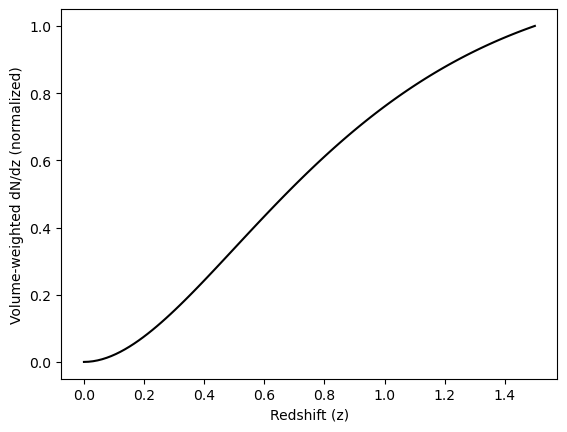

In [7]:
plt.plot(z_bins, dndz, label='dN/dz', color='k')
plt.xlabel('Redshift (z)')
plt.ylabel('Volume-weighted dN/dz (normalized)')

In [8]:
# total_objects = 1e6
# dndz = volume_weights * (total_objects / integral_volume_weights)

# # Verify the normalization (should print close to your total_objects)
# print(f"Total objects from integration: {np.trapezoid(dndz, z_bins):.1f}")
# print(f"Target total objects: {total_objects}")

## Galaxies

In [9]:
bias_gal = 1.5

nbar_gal = 1e-1 # 1e-1 gives ~11M; 1e-2 gives 1.1M
#dndz_gal = np.full_like(z_bins, nbar_gal) #constant density
dndz_gal = nbar_gal * dndz # volume-weighted

# distribute the dN/dz over the linear window functions
# ngal_arr is in shells
ngal_arr = glass.partition(z_bins, dndz_gal, shells)

## AGN

In [10]:
bias_agn = 2.5

nbar_agn = 1e-3 # 1e-2 gives 1.1M; 1e-3 gives ~110k; 1e-4 gives 11k
#dndz_agn = np.full_like(z_bins, nbar_agn) #constant density
dndz_agn = nbar_agn * dndz #volume-weighted

# distribute the dN/dz over the linear window functions
nagn_arr = glass.partition(z_bins, dndz_agn, shells)

In [11]:
tag_mock += f'_ratioNgalNagn{round(nbar_gal/nbar_agn):d}'
print(tag_mock)

_ratioNgalNagn100


# Plot tracer sample properties


In [12]:
z_effs = np.array([shells[i].zeff for i in range(len(shells))])

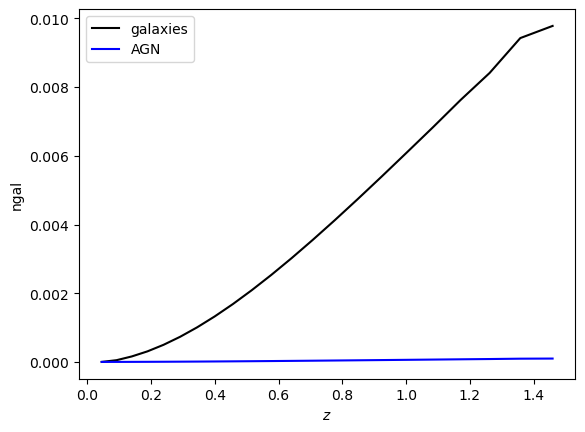

In [13]:
plt.plot(z_effs, ngal_arr, label='galaxies', color='black')
plt.plot(z_effs, nagn_arr, label='AGN', color='blue')
plt.xlabel(r'$z$')
plt.ylabel('ngal')
plt.legend()

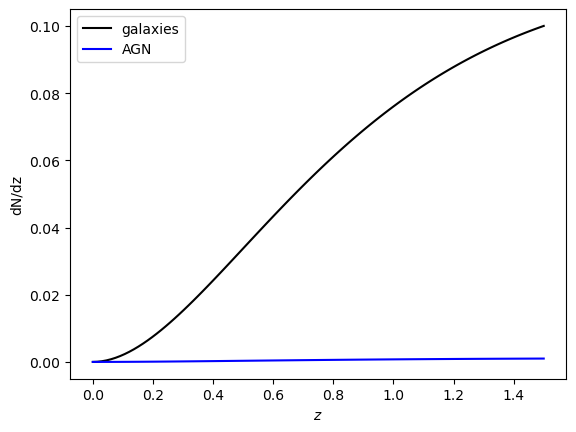

In [14]:
plt.plot(z_bins, dndz_gal, label='galaxies', color='black')
plt.plot(z_bins, dndz_agn, label='AGN', color='blue')
plt.xlabel(r'$z$')
plt.ylabel('dN/dz')
plt.legend()

In [15]:
# Function to compute 3D Cartesian positions from lon, lat, and redshift arrays
def compute_3d_positions(lon, lat, redshift):
    x = redshift * np.cos(np.deg2rad(lon)) * np.cos(np.deg2rad(lat))
    y = redshift * np.sin(np.deg2rad(lon)) * np.cos(np.deg2rad(lat))
    z = redshift * np.sin(np.deg2rad(lat))
    return np.stack([x, y, z], axis=-1)

In [16]:

# Define tracers as a dictionary
tracers = {
    'galaxies': {'bias': bias_gal, 'N': ngal_arr},
    'agn': {'bias': bias_agn, 'N': nagn_arr},
}

positions_3d = {name: [] for name in tracers}
positions_sky = {name: [] for name in tracers}  # Will hold (ra, dec, z)

matter = list(matter)  # Convert generator to a list for multiple iterations
for tracer_name, tracer_dict in tracers.items():
    print(f"Processing tracer: {tracer_name}")
    for i, delta_i in enumerate(matter):
        print("Processing shell:", i)
        # Get all positions for this shell and tracer
        positions_from_delta = glass.positions_from_delta(
            tracer_dict['N'][i],
            delta_i,
            bias=tracer_dict['bias'],
            rng=rng,
        )
        #print(f"Shell {i}: {len(list(positions_from_delta))} positions")
        for lon, lat, count in positions_from_delta:
            # Sample redshifts for these sources
            z = glass.redshifts(count, shells[i], rng=rng)
            # Store sky positions (ra, dec, z)
            sky_pos = np.stack([lon, lat, z], axis=-1)
            print(f"Tracer {tracer_name}, Shell {i}: {len(sky_pos)} positions")
            positions_sky[tracer_name].append(sky_pos)
            # Store 3D positions
            pos = compute_3d_positions(lon, lat, z)
            positions_3d[tracer_name].append(pos)

# Concatenate all positions for each tracer into a single array
for name in positions_3d:
    positions_3d[name] = np.concatenate(positions_3d[name], axis=0)
for name in positions_sky:
    positions_sky[name] = np.concatenate(positions_sky[name], axis=0)
    # Normalize the right ascension (RA) to be in the range [0, 360)
    positions_sky[name][:, 0] = positions_sky[name][:, 0] % 360

# positions_3d['galaxies'] and positions_3d['agn'] are arrays of shape (N, 3) for (x, y, z)
# positions_sky['galaxies'] and positions_sky['agn'] are arrays of shape (N, 3) for (ra, dec, z)

Processing tracer: galaxies
Processing shell: 0
Processing shell: 1
Tracer galaxies, Shell 1: 7521 positions
Processing shell: 2
Tracer galaxies, Shell 2: 23910 positions
Processing shell: 3
Tracer galaxies, Shell 3: 45805 positions
Processing shell: 4
Tracer galaxies, Shell 4: 73851 positions
Processing shell: 5
Tracer galaxies, Shell 5: 108682 positions
Processing shell: 6
Tracer galaxies, Shell 6: 149565 positions
Processing shell: 7
Tracer galaxies, Shell 7: 196016 positions
Processing shell: 8
Tracer galaxies, Shell 8: 250001 positions
Processing shell: 9
Tracer galaxies, Shell 9: 309428 positions
Processing shell: 10
Tracer galaxies, Shell 10: 375250 positions
Processing shell: 11
Tracer galaxies, Shell 11: 447785 positions
Processing shell: 12
Tracer galaxies, Shell 12: 526545 positions
Processing shell: 13
Tracer galaxies, Shell 13: 612742 positions
Processing shell: 14
Tracer galaxies, Shell 14: 704848 positions
Processing shell: 15
Tracer galaxies, Shell 15: 801261 positions


In [17]:
print(f"Galaxies positions shape: {positions_sky['galaxies'].shape}")
print(f"AGN positions shape: {positions_sky['agn'].shape}")

Galaxies positions shape: (11784373, 3)
AGN positions shape: (117882, 3)


In [18]:
# Prepare RA and Dec arrays for plotting from positions_sky
ra_gal = positions_sky['galaxies'][:, 0]
ra_agn = positions_sky['agn'][:, 0]
dec_gal = positions_sky['galaxies'][:, 1]
dec_agn = positions_sky['agn'][:, 1]
z_gal = positions_sky['galaxies'][:, 2]
z_agn = positions_sky['agn'][:, 2]

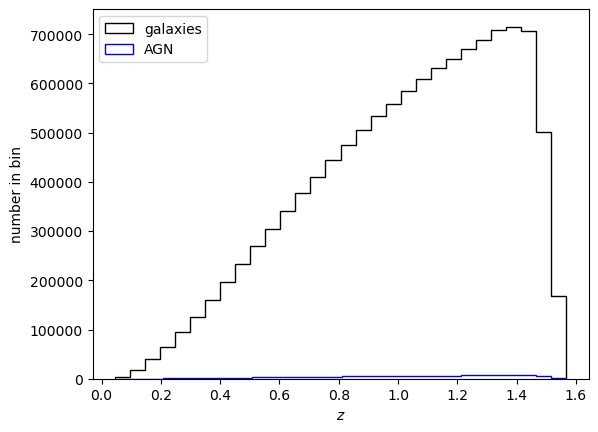

In [19]:
bins = 30
plt.hist(z_gal, label='galaxies', color='black', density=False, bins=bins, histtype='step')
plt.hist(z_agn, label='AGN', color='blue', density=False, bins=bins, histtype='step')
plt.xlabel(r'$z$')
plt.ylabel('number in bin')
plt.legend()

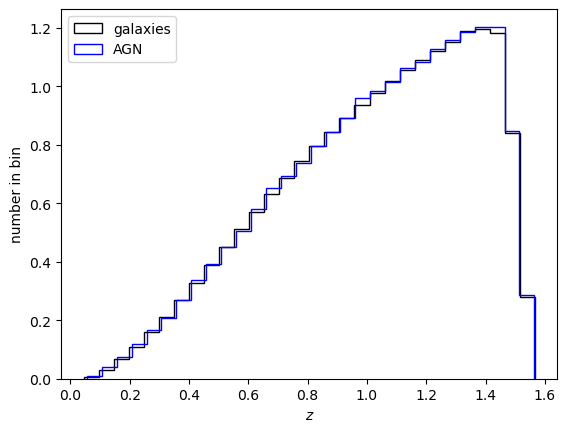

In [20]:
bins = 30
plt.hist(z_gal, label='galaxies', color='black', density=True, bins=bins, histtype='step')
plt.hist(z_agn, label='AGN', color='blue', density=True, bins=bins, histtype='step')
plt.xlabel(r'$z$')
plt.ylabel('number in bin')
plt.legend()

(<Figure size 1000x600 with 1 Axes>, <MollweideAxes: >)

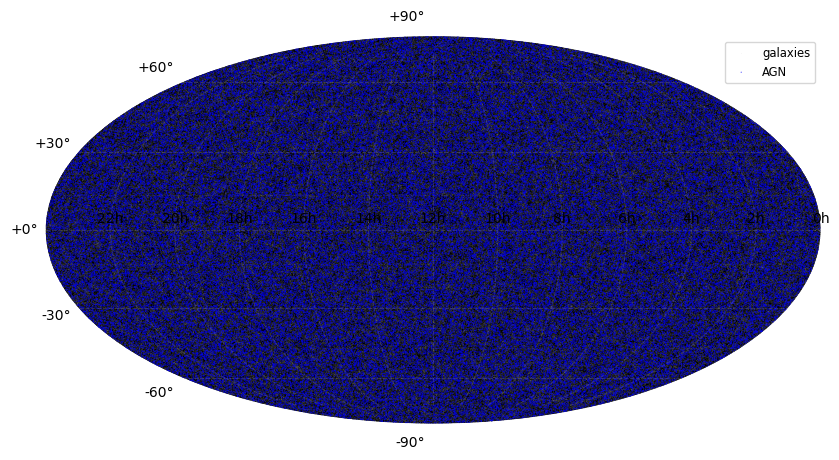

In [21]:
ra_arr = [ra_gal, ra_agn]
dec_arr = [dec_gal, dec_agn]

c_arr = ['k', 'b']
alpha_arr = [0.1, 0.5]

s_arr = [0.2, 1]
label_arr = ['galaxies', 'AGN']

plotter.create_skyplot(ra_arr, dec_arr, alpha_arr=alpha_arr, s_arr=s_arr, c_arr=c_arr, label_arr=label_arr)

# Select sources for GW injection, with our redshift prior

In [ ]:
N_gal = positions_sky['galaxies'].shape[0]
N_agn = positions_sky['agn'].shape[0]   

f_agn = 0.25
tag_mock += f'_fagn{f_agn}'
frac_gal, frac_agn = utils.compute_gw_host_fractions(N_gal, N_agn, f_agn)

A_norm: 8.4831e-06
Frac per object if f=0: 8.4018e-08
denominator: 117882.0
Frac gal: 0.0000
Frac agn: 1.0000
Frac agn phys: 1.0000
Frac agn nonphys: 0.0000
Total fraction (should=1): 1.0000


In [23]:
N_gw = 1000

N_gw_gal = round(frac_gal * N_gw)
N_gw_agn = round(frac_agn * N_gw)
print(f"Number of GW sources in galaxies: {N_gw_gal}")
print(f"Number of GW sources in AGN: {N_gw_agn}")
# Randomly select indices for GW sources in galaxies and AGN
i_gw_gal = rng.choice(np.arange(N_gal), N_gw_gal, replace=False)
i_gw_agn = rng.choice(np.arange(N_agn), N_gw_agn, replace=False)

Number of GW sources in galaxies: 0
Number of GW sources in AGN: 1000


(<Figure size 1000x600 with 1 Axes>, <MollweideAxes: >)

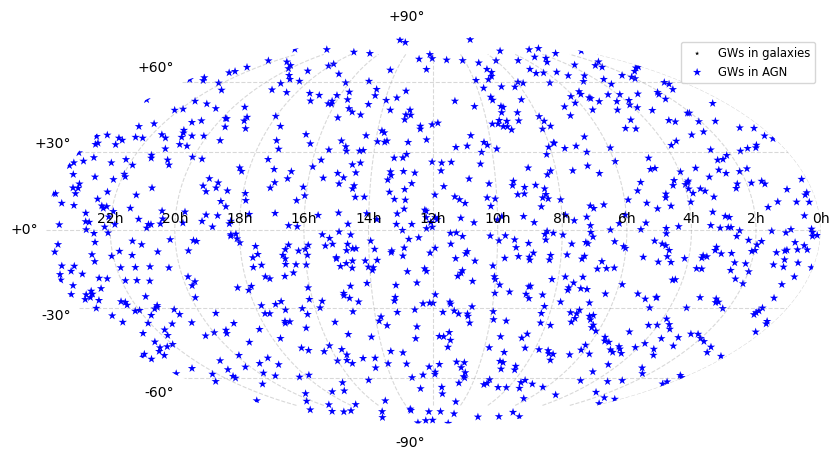

In [24]:
ra_gw_arr = [ra_gal[i_gw_gal], ra_agn[i_gw_agn]]
dec_gw_arr = [dec_gal[i_gw_gal], dec_agn[i_gw_agn]]
z_gw_arr = [z_gal[i_gw_gal], z_agn[i_gw_agn]]

c_arr = ['k', 'b']
alpha_arr = [1, 1]
s_arr = [10, 40]

label_arr = ['GWs in galaxies', 'GWs in AGN']
marker_arr = ['*', '*']

plotter.create_skyplot(ra_gw_arr, dec_gw_arr, alpha_arr=alpha_arr, s_arr=s_arr, 
                       c_arr=c_arr, label_arr=label_arr, marker_arr=marker_arr)

In [25]:
def save_mock(fn_mock, ra_gal, dec_gal, z_gal,
              ra_agn, dec_agn, z_agn):# Save arrays to HDF5 file
    compression = 'gzip'
    compression_opts = 9
    with h5py.File(fn_mock, 'w') as f:
        # Create datasets with compression
        f.create_dataset('ra_gal', data=ra_gal, compression=compression, compression_opts=compression_opts)
        f.create_dataset('dec_gal', data=dec_gal, compression=compression, compression_opts=compression_opts)
        f.create_dataset('z_gal', data=z_gal, compression=compression, compression_opts=compression_opts)
        f.create_dataset('ra_agn', data=ra_agn, compression=compression, compression_opts=compression_opts)
        f.create_dataset('dec_agn', data=dec_agn, compression=compression, compression_opts=compression_opts)
        f.create_dataset('z_agn', data=z_agn, compression=compression, compression_opts=compression_opts)
        f.create_dataset('i_gw_gal', data=i_gw_gal, compression=compression, compression_opts=compression_opts)
        f.create_dataset('i_gw_agn', data=i_gw_agn, compression=compression, compression_opts=compression_opts)
        # attributes of sim
        f.attrs['n_gal'] = N_gal
        f.attrs['n_agn'] = N_agn
        f.attrs['f_agn'] = f_agn
        f.attrs['b1_gal'] = bias_gal
        f.attrs['b1_agn'] = bias_agn
        f.attrs['n_gw'] = N_gw
        f.attrs['z_max'] = z_max
        f.attrs['nside'] = nside
        f.attrs['seed'] = seed
        # cosmology
        f.attrs['h'] = h
        f.attrs['Oc'] = Oc
        f.attrs['Ob'] = Ob
    print(f"Mock saved to {fn_mock}")

In [26]:
fn_mock = f'../data/mocks_glass/mock_seed{seed}{tag_mock}.hdf5'
if save==True:
    save_mock(fn_mock, ra_gal, dec_gal, z_gal, ra_agn, dec_agn, z_agn)

Mock saved to ../data/mocks_glass/mock_seed42_ratioNgalNagn100_fagn1.0.hdf5


# investigate dep on N and f

In [27]:
N_gal = 10000
ratio_agn_arr = [1e-3, 1e-2, 1e-1, 1.0]

#f_agn_arr = np.linspace(0.0, 1.01, 101)
n_f_bins = 100
bin_width = 1.0/n_f_bins
f_agn_arr = np.arange(0.0, 1.0+bin_width, bin_width)

frac_agn_dict = {}
for ratio_agn in ratio_agn_arr:
    N_agn = int(N_gal * ratio_agn)
    frac_agn_arr = []
    
    for f_agn in f_agn_arr:
        A_norm = 1.0/(N_agn + (1-f_agn)*(N_gal))
        frac_agn_phys = A_norm*f_agn*N_agn
        frac_agn_nonphys = A_norm*(1-f_agn)*N_agn
        frac_agn = frac_agn_phys + frac_agn_nonphys
        frac_gal = A_norm*(1-f_agn)*N_gal
        frac_tot = frac_agn_phys+frac_gal+frac_agn_nonphys
        
        frac_agn_arr.append(frac_agn)
    
    frac_agn_dict[ratio_agn] = np.array(frac_agn_arr)

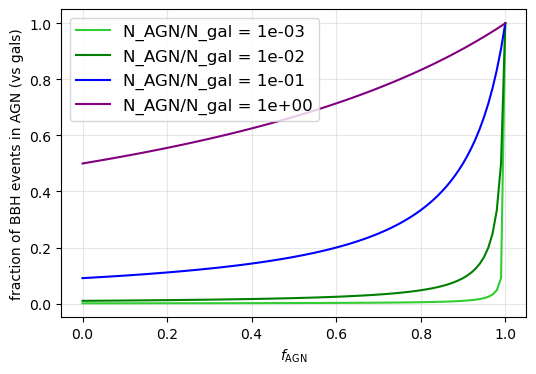

In [28]:
colors = ['limegreen', 'green', 'blue', 'purple']
plt.figure(figsize=(6, 4))
for ratio_agn in ratio_agn_arr:
    plt.plot(f_agn_arr, frac_agn_dict[ratio_agn], 
             label=f'N_AGN/N_gal = {ratio_agn:.0e}',
             color=colors[ratio_agn_arr.index(ratio_agn)])

plt.xlabel(r'$f_{\rm AGN}$')
plt.ylabel(r'fraction of BBH events in AGN (vs gals)')
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()